In [3]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

import matplotlib.pyplot as plt

# Download the 'malaria' dataset

In [6]:
ds_train, ds_info = tfds.load(
    'malaria',
    split='train',
    with_info=True,
    as_supervised=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\voldo\tensorflow_datasets\malaria\incomplete.PJWV4C_1.0.0\malaria-train.tfrecord*...:   0%|…

Dataset malaria downloaded and prepared to C:\Users\voldo\tensorflow_datasets\malaria\1.0.0. Subsequent calls will reuse this data.


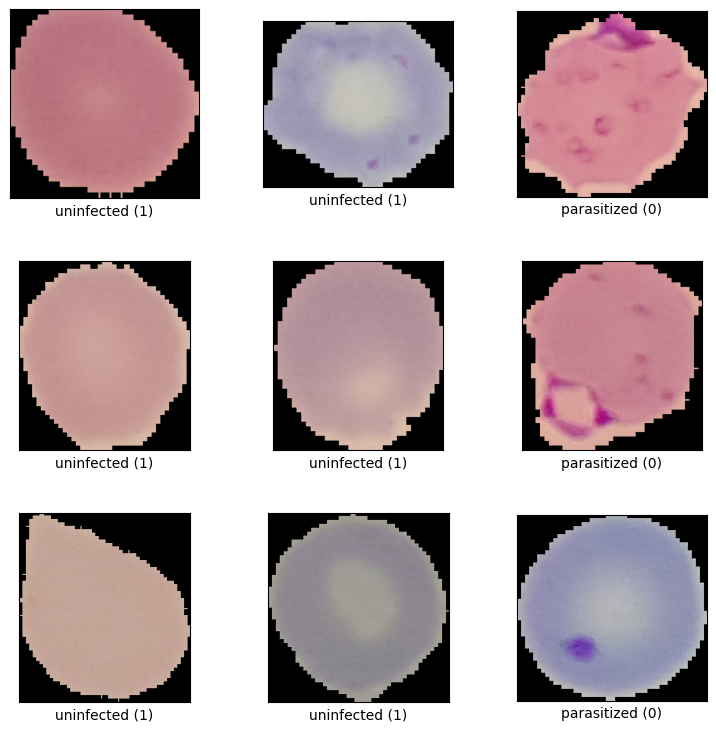

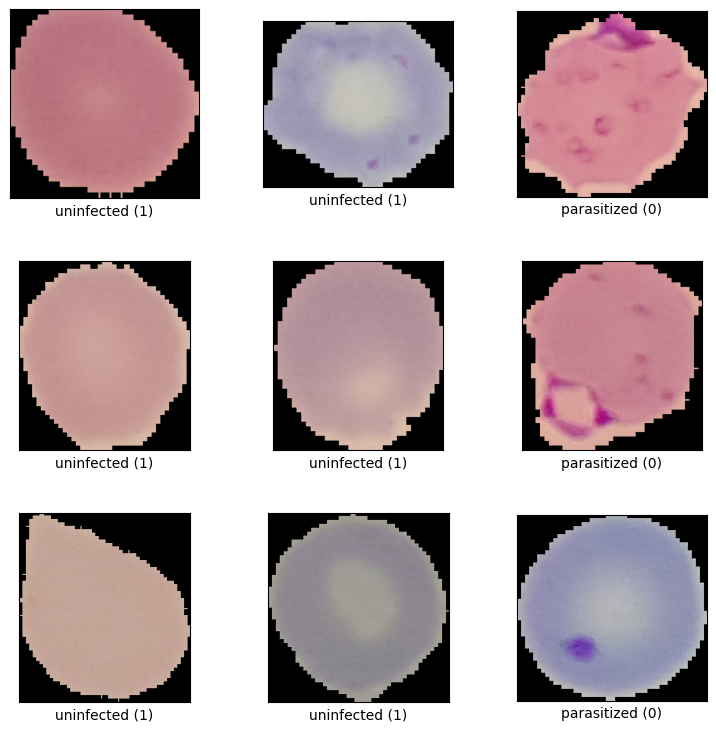

In [7]:
tfds.visualization.show_examples(
    ds=ds_train,
    ds_info=ds_info,
    is_batched=False,
)

In [14]:
class_name = ['parasitized', 'uninfected']

In [8]:
ds_train_ = ds_train.shuffle(buffer_size=10000, reshuffle_each_iteration=False)
num_train_examples = int(0.7 * len(ds_train))
ds_train = ds_train_.take(num_train_examples)
ds_test = ds_train_.skip(num_train_examples)

In [9]:
IMG_SIZE = 160
BATCH_SIZE = 64

In [10]:
def preprocess_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE), method=tf.image.ResizeMethod.GAUSSIAN)
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, tf.one_hot(label, depth=2)

In [11]:
ds_train = ds_train.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

In [12]:
ds_train = ds_train.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

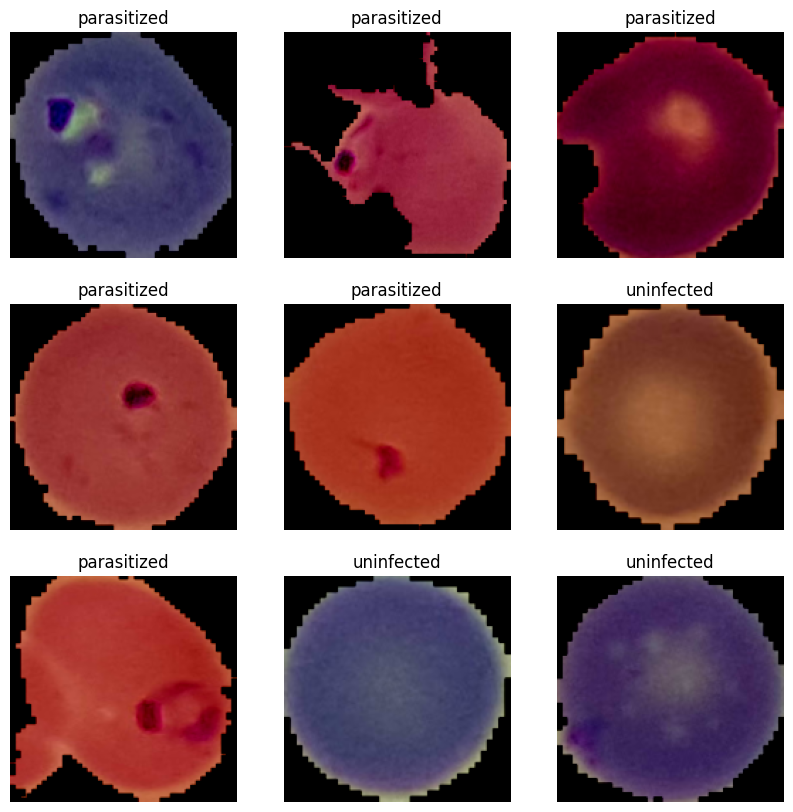

In [15]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[0].numpy())
    plt.title(class_name[np.argmax(label[0])])
    plt.axis("off")

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, Activation, BatchNormalization, MaxPooling2D, Dropout
from tensorflow.keras import regularizers, optimizers

In [20]:
def get_model(base_hidden_units=32, weight_decay=1e-4):
    md = Sequential()
    
    md.add(Input(shape=(IMG_SIZE, IMG_SIZE, 3)))

    # CONV_1
    md.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same',
                  kernel_regularizer=regularizers.l2(weight_decay),
                  ))
    md.add(Activation('relu'))
    md.add(BatchNormalization())

    # CONV_2
    md.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same',
                  kernel_regularizer=regularizers.l2(weight_decay)))
    md.add(Activation('relu'))
    md.add(BatchNormalization())

    # POOL + Dropout
    md.add(MaxPooling2D(pool_size=(3,3)))
    md.add(Dropout(0.2))

    # CONV_3
    md.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same',
                  kernel_regularizer=regularizers.l2(weight_decay)))
    md.add(Activation('relu'))
    md.add(BatchNormalization())

    # CONV_4
    md.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same',
                  kernel_regularizer=regularizers.l2(weight_decay)))
    md.add(Activation('relu'))
    md.add(BatchNormalization())

    # POOL + Dropout
    md.add(MaxPooling2D(pool_size=(3,3)))
    md.add(Dropout(0.3))

    # CONV_5
    md.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same',
                  kernel_regularizer=regularizers.l2(weight_decay)))
    md.add(Activation('relu'))
    md.add(BatchNormalization())

    # CONV_6
    md.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same',
                  kernel_regularizer=regularizers.l2(weight_decay)))
    md.add(Activation('relu'))
    md.add(BatchNormalization())

    # POOL + Dropout
    md.add(MaxPooling2D(pool_size=(2,2)))
    md.add(Dropout(0.4))

    # FC_7
    md.add(Flatten())
    md.add(Dense(2, activation='softmax'))

    return md

In [21]:
model = get_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 160, 160, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 160, 160, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 160, 160, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 160, 160, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 160, 160, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 160, 160, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 53, 53, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 53, 53, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 53, 53, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 53, 53, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 53, 53, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 53, 53, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 17, 17, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 17, 17, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 17, 17, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 17, 17, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 305,186 (1.16 MB)

 Trainable params: 304,290 (1.16 MB)

 Non-trainable params: 896 (3.50 KB)

In [22]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=["accuracy"])

In [24]:
history = model.fit(ds_train, validation_data=ds_test, epochs=1)

302/302 ━━━━━━━━━━━━━━━━━━━━ 575s 2s/step - accuracy: 0.8443 - loss: 0.5908 - val_accuracy: 0.9289 - val_loss: 0.2716


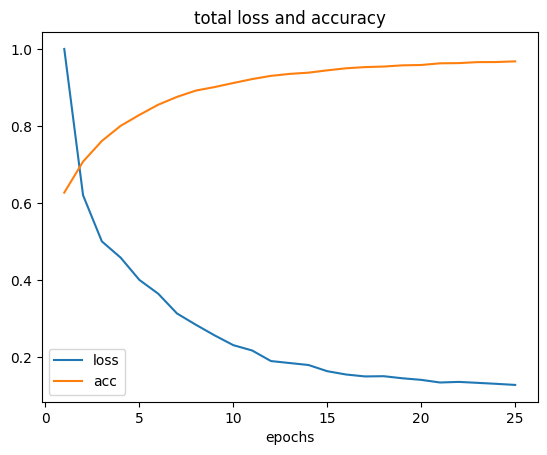

In [15]:
import matplotlib.pyplot as plt
import numpy as np

epoch_array = range(1, len(history.history['loss']) + 1)
loss_array = history.history['loss']
acc_array = history.history['accuracy']

max_loss = max(loss_array)
loss_array = np.array(loss_array) / max_loss

plt.plot(epoch_array, loss_array, label="loss")
plt.plot(epoch_array, acc_array, label="acc")
plt.xlabel("epochs")
plt.title("total loss and accuracy")

plt.legend()
plt.show()

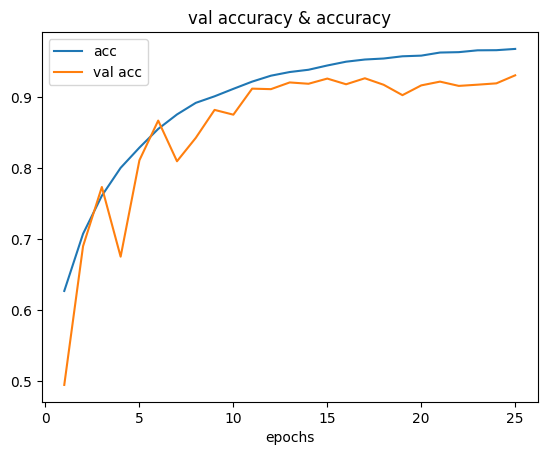

In [16]:
epoch_array = range(1, len(history.history['loss']) + 1)
val_acc_array = history.history['val_accuracy']
acc_array = history.history['accuracy']

plt.plot(epoch_array, acc_array, label="acc")
plt.plot(epoch_array, val_acc_array, label="val acc")
plt.xlabel("epochs")
plt.title("val accuracy & accuracy")

plt.legend()
plt.show()

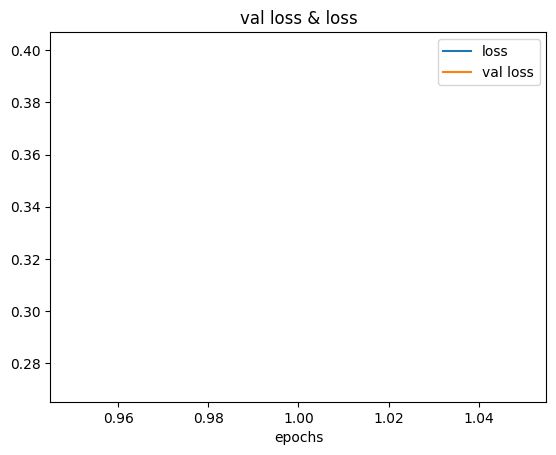

In [25]:
epoch_array = range(1, len(history.history['loss']) + 1)
val_acc_array = history.history['val_loss']
acc_array = history.history['loss']

plt.plot(epoch_array, acc_array, label="loss")
plt.plot(epoch_array, val_acc_array, label="val loss")
plt.xlabel("epochs")
plt.title("val loss & loss")

plt.legend()
plt.show()

In [26]:
results = model.evaluate(ds_test)
print(results)

130/130 ━━━━━━━━━━━━━━━━━━━━ 41s 302ms/step - accuracy: 0.9286 - loss: 0.2709
[0.27164405584335327, 0.9288824200630188]


In [27]:
from matplotlib import rcParams
from matplotlib import pyplot as plt

rcParams["figure.figsize"] = [10, 10]
rcParams['xtick.labelbottom'] = False

259/259 ━━━━━━━━━━━━━━━━━━━━ 41s 155ms/step


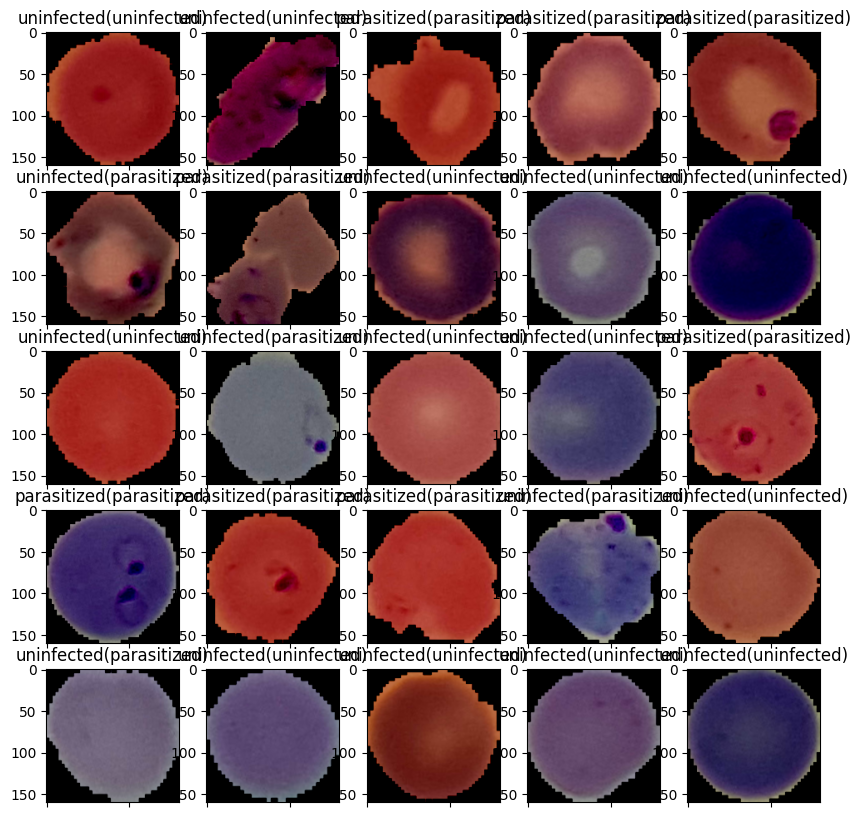

In [28]:
# finally visualize it
x_test = np.concatenate([x for x, y in ds_test], axis=0)
y_test = np.concatenate([y for x, y in ds_test], axis=0)

test_pred = model.predict(x_test)

for idx, elem in enumerate(ds_test.take(25)):
    pred_idx = np.argmax(test_pred[idx])
    true_idx = np.argmax(y_test[idx])
    plt.subplot(5, 5, idx + 1, title=(class_name[pred_idx] + "(" + class_name[true_idx] + ")"))
    plt.imshow(elem[0][0].numpy())

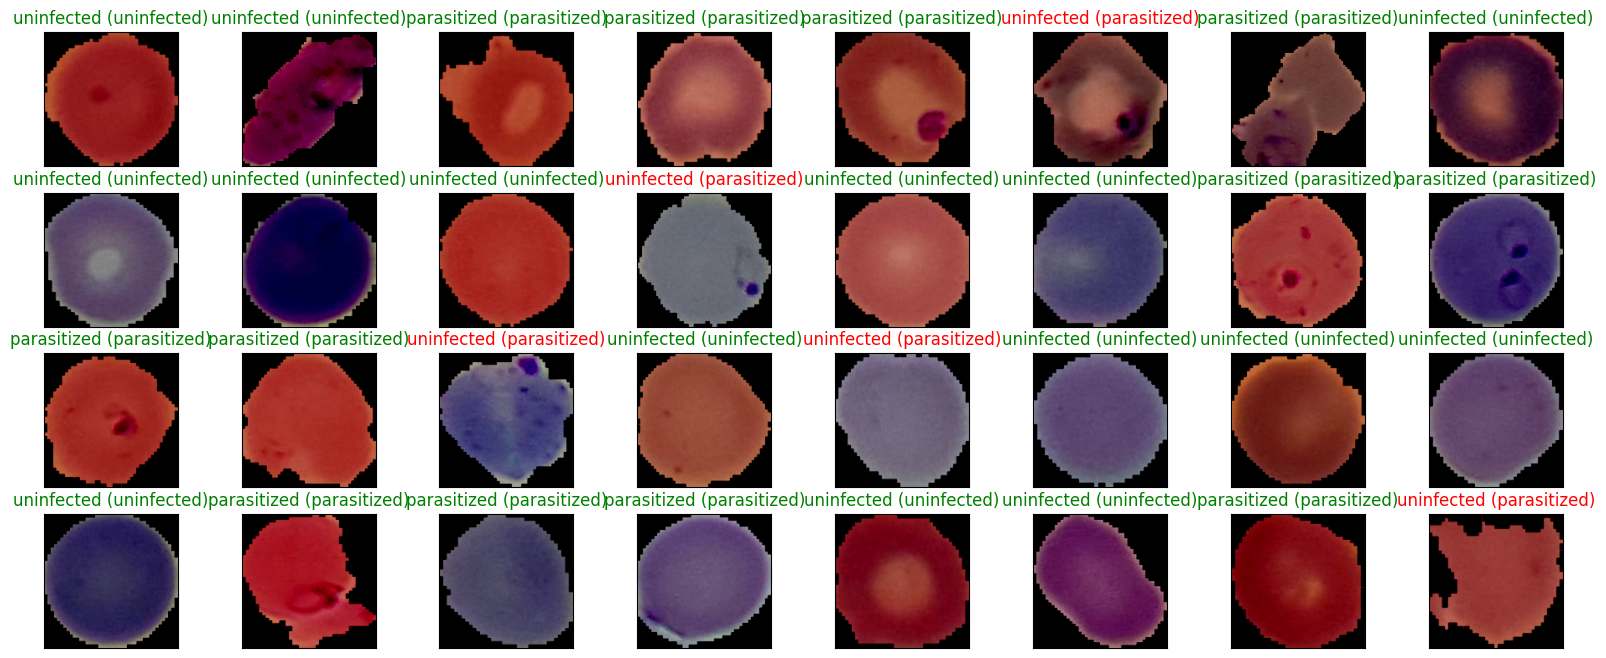

In [29]:
from matplotlib import pyplot

fig = pyplot.figure(figsize=(20, 8))

for idx, elem in enumerate(ds_test.take(32)):
    ax = fig.add_subplot(4, 8, idx + 1, xticks=[], yticks=[])
    ax.imshow(elem[0][0].numpy())
    pred_idx = np.argmax(test_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(class_name[pred_idx], class_name[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))
pyplot.show()